In [2]:
import sem
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

# Create our SEM campaign
ns_3_dir = '../../../../'
script = 'aloha-throughput'
results_dir = 'aloha-results'
campaign = sem.CampaignManager.new(ns_3_dir, script, results_dir,
                                   check_repo=False, overwrite=True)

# Define the parameter space we are interested in exploring
params = {
    'nDevices': 1000,
    'simulationTime': [round(i, 4) for i in np.logspace(0.5, 4, base=60, num=100, dtype='float')],
    'radius': [0, 7500],
    'interferenceMatrix': lambda p: ["aloha"] if p["radius"] == 0 else ["goursaud"],
}
runs = 10

# Run simulations with the above parameter space
campaign.run_missing_simulations(params, runs)

Building ns-3: 100%|███████████████████████████████████████████████████| [00:11<00:00]
Running simulations: 100%|████████████████| 2000/2000 [18:29<00:00,  1.80simulation/s]


In [3]:
example_result = campaign.db.get_complete_results()[0]
display(example_result)
print(sem.utils.get_command_from_result('aloha-throughput', example_result))

{'params': {'nDevices': 1000,
  'simulationTime': 61184.2269,
  'radius': 0,
  'interferenceMatrix': 'aloha',
  'RngRun': 1242},
 'meta': {'id': 'f9c489b9-ad74-4886-bcd9-5bce755396b5',
  'elapsed_time': 2.2093164920806885,
  'exitcode': 0},
 'output': {'stderr': '',
  'durations.txt': '112896 205312 369664 657408 1478656 2629632 ',
  'stdout': '1000 1000\n0 0\n0 0\n0 0\n0 0\n0 0\n'}}

python3 waf --run "aloha-throughput --nDevices=1000 --simulationTime=61184.2269 --radius=0 --interferenceMatrix=aloha --RngRun=1242"


In [4]:
@sem.utils.output_labels(['G', 'S'])
def get_throughput(result):
    """
    Extract the probability of success from the simulation output
    """
    durations = [float(i)/1e6 for i in result['output']['durations.txt'].split()]
    sent = 0
    g = 0
    s = 0
    sf = 7
    for sf_performance in result['output']['stdout'].splitlines():
        sent, received = [float(i) for i in sf_performance.split()]
        current_g = sent * durations[sf-7] / result['params']['simulationTime']
        g += current_g
        if sent == 0:
            s += 0
        else:
            s += current_g * received / sent
        sf += 1
    return [g, s]

In [5]:
results = campaign.get_results_as_dataframe(get_throughput,
                                            params=params)

In [6]:
results = results.join(results.groupby(list(params.keys()))['G'].mean(), on=list(params.keys()), rsuffix='_avg')

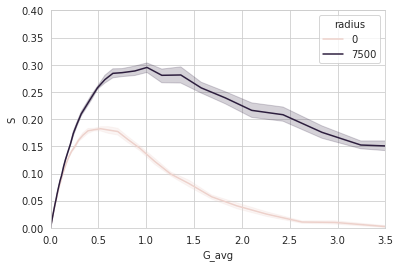

In [7]:
sns.lineplot(data=results,
            x='G_avg', 
            y='S',
            hue='radius')
plt.ylim([0, 0.4])
plt.xlim([0, 3.5])
plt.show()